<a href="https://colab.research.google.com/github/iamsoroush/mnist_inception_finetune/blob/master/mnist_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a> <br>
# Import Required Libraries

As the first step, we need to import needed libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
 
config = tf.ConfigProto()
# 指定可见显卡
# config.gpu_options.visible_device_list="1"
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
#不满显存, 自适应分配
config.gpu_options.allow_growth=True   
sess = tf.Session(config=config)
KTF.set_session(sess)

Using TensorFlow backend.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Input, UpSampling3D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import InceptionV3

from keras.datasets import mnist, cifar10

In [3]:
def split_dataset(datapath, p):
    sample_folder_list = os.listdir(datapath) ##各个样本的文件夹
    sample_folder_list_dict = {} ##各个文件夹下的图片路径信息
    train_dir_dict = {} ##用作训练的样本路径集合
    test_dir_dict = {}##用作测试的样本路径集合

    for folder in sample_folder_list:
        sample_folder_list_dict[folder] = os.listdir(datapath+folder)
        train_dir_dict[folder] = random.sample(sample_folder_list_dict[folder], p)
        test_dir_dict[folder] = list(set(sample_folder_list_dict[folder])-set(train_dir_dict[folder]))

    train_label = []
    train_data = []

    test_label = []
    test_data = []

    for key in train_dir_dict:
        for path in train_dir_dict[key]:
            train_label.append(min(int(key[-2:])-1, 37))
            img = cv2.imread(datapath+key+'/'+path)
            img = cv2.resize(img, (42, 48))
            train_data.append(img)
        
        for path in test_dir_dict[key]:
            test_label.append(min(int(key[-2:])-1, 37))
            img = cv2.imread(datapath+key+'/'+path)
            img = cv2.resize(img, (42, 48))
            test_data.append(img)

    return train_data, train_label, test_data, test_label

In [4]:
import random
import cv2
datapath = '/root/zhb/Documents/PR/data/' 
train_data, train_label, test_data, test_label = split_dataset(datapath, 30)
x_train = np.asarray(train_data) 
train_label = np.asarray(train_label) 
x_test = np.asarray(test_data) 
test_label = np.asarray(test_label)
y_train = to_categorical(train_label, 38)
y_test = to_categorical(test_label, 38)

# Load and Prepare Data

## cifar 10 dataset

In [36]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
x_train = X_train.reshape(X_train.shape[0], 32, 32, 3).astype('float32')
x_test = X_test.reshape(X_test.shape[0], 32, 32, 3).astype('float32')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('X train: ', x_train.shape)
print('y train: ', y_train.shape)
print('X test: ', x_test.shape)
print('y test: ', y_test.shape)

x_train = (x_train / 255).astype('float32')
x_test = (x_test / 255).astype('float32')
#expand 1 more dimention as 1 for colour channel gray
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
print(x_train.shape)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
print(x_test.shape)
y_train = to_categorical(y_train)
num_classes = y_train.shape[1]
y_train.shape

X train:  (60000, 28, 28)
y train:  (60000,)
X test:  (10000, 28, 28)
y test:  (10000,)


The Input in in th shape 1 * 784 arrays. We convert them to an image of 28 * 28 pixel to be able to use convolutional layers.

(60000, 28, 28, 1)
(10000, 28, 28, 1)


We have a number for each image but we need an array.
2 has to be converted to [0, 0, 1, 0, 0 ,0 ,0 ,0 ,0 ,0] 

(60000, 10)

Split training set to train and validation sets:

In [5]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=random_seed)

<a id="9"></a> <br>
# Define the Model

In [7]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

#mnist
# input_inception = Input(shape=(28, 28, 1), dtype='float32', name='inception_input')
#cifar 10
input_inception = Input(shape=(48, 42, 3), dtype='float32', name='inception_input')


# create the base pre-trained model
##cifar 10
x = UpSampling3D(size=(3, 3, 1), data_format="channels_last")(input_inception)

##mnist
# x = UpSampling3D(size=(3, 3, 3), data_format="channels_last")(input_inception)


# x = Conv2D(filters=3, kernel_size=1, padding="same", activation='relu', data_format='channels_last')(x)

x = base_model(x)

# add a global spatial average pooling layer
# x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer
predictions = Dense(38, activation='softmax')(x)

# this is the model we will train
inceptionv3_model = Model(inputs=input_inception, outputs=predictions)

inceptionv3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_input (InputLayer) (None, 48, 42, 3)         0         
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 144, 126, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 38)                38950     
Total para

# Freeze the First 2 Blocks

In [8]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [9]:
for layer in base_model.layers[:64]:
   layer.trainable = False
    
inceptionv3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_input (InputLayer) (None, 48, 42, 3)         0         
_________________________________________________________________
up_sampling3d_2 (UpSampling3 (None, 144, 126, 3)       0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 38)                38950     
Total para

# Compile and Fit the Model

In [10]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [11]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.005, 
                                            min_lr=0.00001)

In [12]:
inceptionv3_model.compile(optimizer=optimizer , loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
inceptionv3_history = inceptionv3_model.fit(x_train, y_train, epochs=100, batch_size=32,
                                            validation_data=(x_val, y_val),
                                            shuffle=True,
                                            callbacks=[learning_rate_reduction])

Train on 912 samples, validate on 228 samples
Epoch 1/100
912/912 [==============================] - 22s 24ms/step - loss: 4.0548 - acc: 0.0329 - val_loss: 11.3732 - val_acc: 0.0263
Epoch 2/100
912/912 [==============================] - 3s 3ms/step - loss: 3.5928 - acc: 0.0735 - val_loss: 8.0538 - val_acc: 0.0351
Epoch 3/100
912/912 [==============================] - 3s 3ms/step - loss: 2.9829 - acc: 0.1853 - val_loss: 3.3160 - val_acc: 0.0833
Epoch 4/100
912/912 [==============================] - 3s 3ms/step - loss: 2.0877 - acc: 0.3969 - val_loss: 4.2018 - val_acc: 0.2061
Epoch 5/100
912/912 [==============================] - 3s 3ms/step - loss: 1.3063 - acc: 0.6228 - val_loss: 6.1572 - val_acc: 0.1535
Epoch 6/100
912/912 [==============================] - 3s 3ms/step - loss: 0.9505 - acc: 0.7412 - val_loss: 3.8330 - val_acc: 0.2895
Epoch 7/100
912/912 [==============================] - 3s 3ms/step - loss: 0.5331 - acc: 0.8509 - val_loss: 5.7823 - val_acc: 0.4123
Epoch 8/100
912/912 

912/912 [==============================] - 3s 3ms/step - loss: 0.0273 - acc: 0.9945 - val_loss: 0.2556 - val_acc: 0.9474
Epoch 62/100
912/912 [==============================] - 3s 3ms/step - loss: 0.0320 - acc: 0.9912 - val_loss: 0.2578 - val_acc: 0.9474
Epoch 63/100
912/912 [==============================] - 3s 3ms/step - loss: 0.0286 - acc: 0.9890 - val_loss: 0.2579 - val_acc: 0.9474
Epoch 64/100
912/912 [==============================] - 3s 3ms/step - loss: 0.0279 - acc: 0.9923 - val_loss: 0.2563 - val_acc: 0.9474
Epoch 65/100
912/912 [==============================] - 3s 3ms/step - loss: 0.0254 - acc: 0.9912 - val_loss: 0.2570 - val_acc: 0.9474
Epoch 66/100
912/912 [==============================] - 3s 3ms/step - loss: 0.0271 - acc: 0.9912 - val_loss: 0.2587 - val_acc: 0.9474
Epoch 67/100
912/912 [==============================] - 3s 3ms/step - loss: 0.0306 - acc: 0.9901 - val_loss: 0.2596 - val_acc: 0.9518
Epoch 68/100
912/912 [==============================] - 3s 3ms/step - loss:

In [26]:
inceptionv3_model.save('inceptionv3_face.h5')

In [15]:
print(inceptionv3_history.history.keys())


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


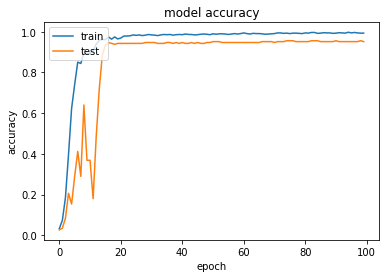

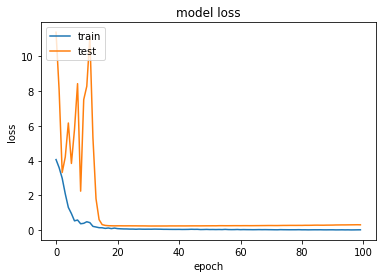

In [17]:
import matplotlib.pyplot as plt

plt.plot(inceptionv3_history.history['acc'])
plt.plot(inceptionv3_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(inceptionv3_history.history['loss'])
plt.plot(inceptionv3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
# y_pred = inceptionv3_model.predict(x_test, verbose=0)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(912, 48, 42, 3)
(1330, 48, 42, 3)
(228, 48, 42, 3)


In [24]:
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))

In [25]:
print(accuracy)

0.9766917293233083


In [51]:
print(np.argmax(y_pred[:10], axis=1))

[5 8 8 0 6 6 1 6 3 1]


In [52]:
y_test[:10]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)